# stepik ml contest

    предсказать уйдет ли пользоваетль из курса или нет.
    обычно 5-10 процентов заканчиивает онлайн курс.
    как они проходят, где были проблемы.
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



In [2]:
file = 'event_data_train.csv' # файл с событиями которые происходят на курсе
events_data = pd.read_csv(file)
submissions_data = pd.read_csv('submissions_data_train.csv') # файл с данными о сабмитах

    Посмотрим на данные. больше сырые данные. где просто на каждое событие есть лог с юзер айди и временем.
    тут нет ни фичей, ни целевой переменной (закончил или нет)
    короче нужно подготовить данные, что бы они не были сырыми.
    На что сразу обратить внимание? колонка timestamp это время! там количество секунд с начла времен(1 января 1970). Типа просто 
    целое число. и там будет лега сравнивать это время
    Надо проверить что эти данные валидные и содержат именно те наблюдения которые должны содеражать

In [3]:
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [4]:
events_data['action'].unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)


# преобразовать дату

In [5]:
# раз это данные о том как пользователь проходит курс. надо посмотерть что делал пользователь и когда
# сначала переведу столбец с timestamp в формат даты
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')

In [6]:
events_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [7]:
# данные за три года
events_data.date.min(), events_data.date.max()

(Timestamp('2015-06-15 04:00:48'), Timestamp('2018-05-19 23:33:31'))

In [8]:
events_data['day'] = events_data.date.dt.date

In [9]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


# первый граффик. граффик активности пользователей по дням

<Axes: xlabel='day'>

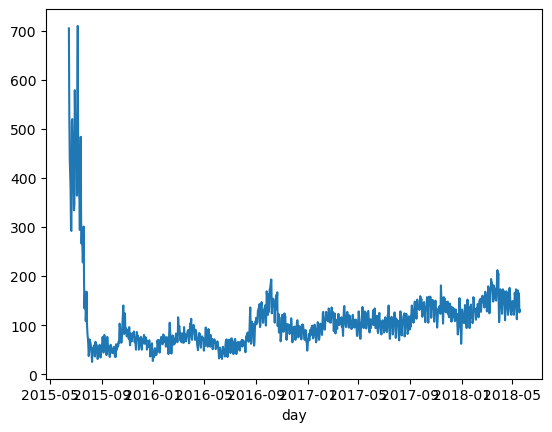

In [10]:
# теперь есть конкретный день. и можно построить граффик активности пользователей
events_data.groupby('day') \
    .user_id.nunique().plot()

<Axes: xlabel='day'>

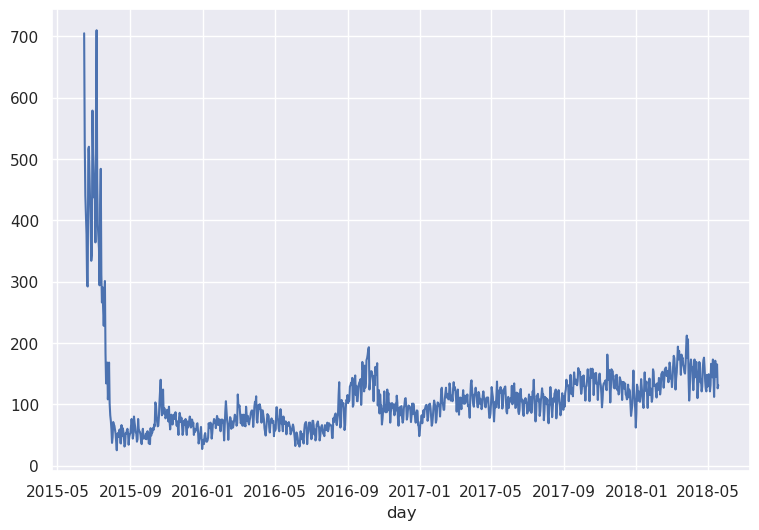

In [11]:
# что бы график был более читаем можно использовать seaborn
sns.set(rc={'figure.figsize': (9, 6)}) # установка размера графика
events_data.groupby('day') \
    .user_id.nunique().plot()

# график баллов 
    пройденые степы

<Axes: >

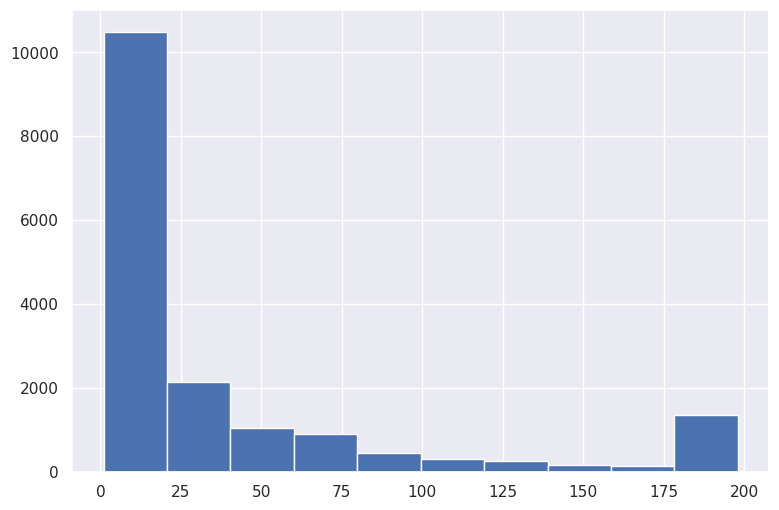

In [12]:
# неправильное решение. так как есть пользователи у которых вообще нет passed_steps
# проверять на каждом шаге. что число уникальных пользователй не меняется!!!
events_data[events_data.action == 'passed'] \
    .groupby('user_id', as_index=False) \
    .agg({'step_id': 'count'}) \
    .rename(columns={'step_id': 'passed_steps'}).passed_steps.hist()

In [13]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


<Axes: >

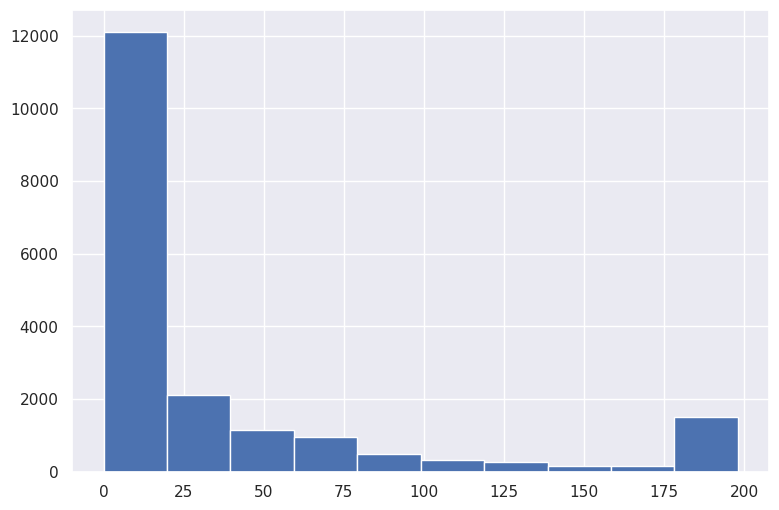

In [14]:
# правильное решение с помощью pivot_table.
# какая калонка для индекса, какая для столбцов, какая для значений, какой агрегирующая функция, fill_value - что подставить на место NaN
# сделаем таблицу где индексом будет user_id, столбцами будут действия, значениями количество шагов пройденых
events_data.pivot_table(index='user_id',
                        columns='action',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index().discovered.hist()   

In [15]:
# есть колонка submission_status и step_id можно понять как долго пользователь пытался решить задачу
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [16]:
# сначала переведу столбец с timestamp в формат даты 
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date

In [17]:
users_scores = submissions_data.pivot_table(index='user_id',
                        columns='submission_status',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index()

In [18]:
# видно сколько быыло правильных и неправильных ответов пользователей
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


# создание фичей. 
    сколько было правильных и неправильных ответов, сколько всего было попыток и тд 
    и потом посмотрю, как отличаются эти данные у пользоваетелей которые закончили курс  и у тех которые бросили

    и как понять что пользовватель ушел вообще с курса? типа если он не появлялся несколько недель? или месяцев?
    Понять какие были промежутки перерывы у пользователей.
    Надо понять. какой промежуток отсутсвия на  курсе можно считать пороговым, что бы счиать что пользователь слился

In [19]:
# здесь видно когда пользователь последний раз пытался решить задачу.
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']).head()

,user_id,day,timestamp
0,17632,2015-06-15,1434340848
36,12494,2015-06-15,1434341931
59,442,2015-06-15,1434342029
62,22254,2015-06-15,1434342042
94,6646,2015-06-15,1434342230


In [20]:
# сохраняю для каждого юзера, уникальные timestamp в которые он был онлайн
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day'])\
    .groupby('user_id')['timestamp'].apply(list)\
    .apply(np.diff).values # np.diff - разница между соседними элементами (difference)

gap_data

array([array([], dtype=int64), array([4843602]),
       array([6899249,  182484,   93710, 2768870,  171400,   78712]), ...,
       array([   86128,   136759,    94899,  1422583, 14347289,   505061,
                 98252,    57019])                                       ,
       array([1567990]), array([], dtype=int64)], dtype=object)

In [21]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0)) # соединяю все массивы в один и сохраняю в Series
gap_data # значения разницы между двуммя захходами на курс

0         4843602
1         6899249
2          182484
3           93710
4         2768870
           ...   
97867    14347289
97868      505061
97869       98252
97870       57019
97871     1567990
Length: 97872, dtype: int64

In [22]:
gap_data = gap_data / (24 * 60 * 60) # перевожу в дни


<Axes: >

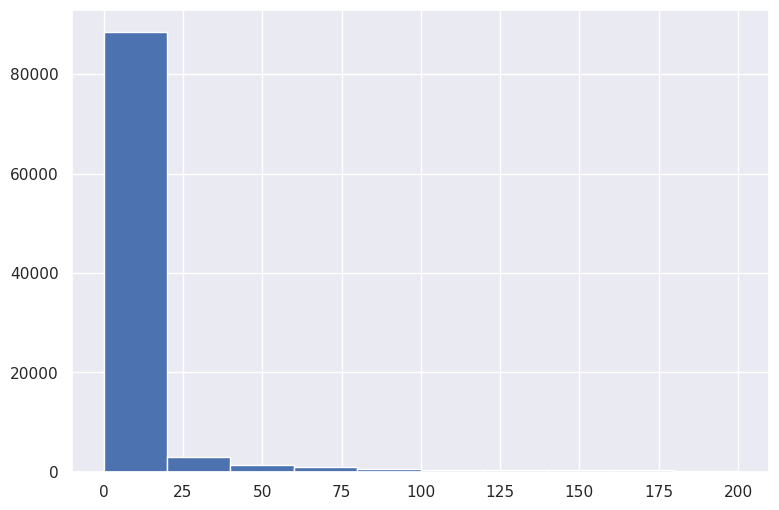

In [23]:
gap_data[gap_data < 200].hist()

In [24]:
gap_data.quantile(0.90) # 18 дней. 90% пользователей возвращаются на курс в течении 18 дней

18.325995370370403

In [25]:
gap_data.quantile(0.95) # 59 дней. 95% пользователей возвращаются на курс в течении 59 дней

59.760440972222156

In [26]:
# возьму среднее междду ними. например 30 дней. что бы определить когда пользователь считается дропнувшимся

In [27]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [28]:
submissions_data.groupby('user_id')['day'].nunique().idxmax()

1046

In [29]:
# Фильтруем только строки со статусом "correct"
correct_submissions = submissions_data[submissions_data['submission_status'] == 'correct']

# Группируем по user_id и считаем количество записей
user_correct_counts = correct_submissions.groupby('user_id').size()

# Сортируем по убыванию и выбираем топ-10
top_10_users = user_correct_counts.sort_values(ascending=False).head(1)

print(top_10_users)


user_id
1046    421
dtype: int64


In [30]:
t = correct_submissions.groupby('user_id', as_index=False).count()

In [31]:
t.sort_values(by='submission_status', ascending=False).head(1)

,user_id,step_id,timestamp,submission_status,date,day
433,1046,421,421,421,421,421


    если человек не получили сертификат и не появляется на курсе более 30 дней отставим его считаться как дропнувший

In [32]:
events_data.tail() # смотрю на конец датасета, что бы посмотреть на последний timestamp

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


In [33]:
30 * 24 * 60 * 60 # в секундах 30 дней

2592000

In [34]:
users_data = events_data.groupby('user_id', as_index=False).agg({'timestamp': 'max'})\
    .rename(columns={'timestamp': 'last_timestamp'})

users_data


,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660
...,...,...
19229,26790,1517495987
19230,26793,1510225034
19231,26794,1512035039
19232,26797,1509995096


In [35]:
now = 1526772811
drop_out_threshold = 2592000

In [36]:
# теперь нужно понять, сколко времени прошло с момента последенго посещения курса на текущий день
# текущий день это как будто 2018-05-19
# получается я из таймштампа СЕЙЧАС вычиатю таймштамп последний его. И проверяю больше ли чем 30 дней прошло
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_threshold
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [37]:
users_data.value_counts('is_gone_user')

is_gone_user
True     17844
False     1390
Name: count, dtype: int64

    это пока не тот датафрейм который буду исопльзовтаь для обучения модели.
    это пока сводная таблица по юзерам.
    еще добавим баллы и суммарное число попыток

In [38]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [39]:
# соеденю таблицы. использую оутер джойнку, даже если есть в одной таблице NaN
users_data = users_data.merge(users_scores, on='user_id' ,how='outer')

In [40]:
users_data = users_data.fillna(0)

In [41]:
users_data.head(20)

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0
5,8,1481466913,True,9.0,21.0
6,9,1484999497,True,0.0,0.0
7,11,1526140625,False,0.0,0.0
8,14,1436368676,True,0.0,1.0
9,16,1513162585,True,77.0,106.0


In [42]:
users_events_data = events_data.pivot_table(index='user_id',
                        columns='action',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index()

In [43]:
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [44]:
users_data = users_data.merge(users_events_data, how='outer', on='user_id')

In [45]:
# группирую по юзер айди и беру число уникальных дней
users_days = events_data.groupby('user_id').day.nunique()

In [50]:
# to_frame() перевожу в датафрейм reset_index() что бы убрать мультииндекс
users_days = users_days.to_frame().reset_index()

In [51]:
users_data = users_data.merge(users_days, how='outer', on='user_id')

In [52]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


In [55]:
users_data.user_id.nunique()


19234

In [56]:
# правда ли что юзер закончил курс. Набрал больше 170 пройденых шагов
users_data['passed_corse'] = users_data.passed > 170

In [59]:
users_data.passed_corse.value_counts()

passed_corse
False    17809
True      1425
Name: count, dtype: int64